Read satellite data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def read_satellite_data(veg_type, satellite):
    # Load vegetation class table
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    # Filter for Forest classes
    if veg_type in (11, 12, 13, 14):
        df = df[df['veg_class'].isin([veg_type])]#.iloc[0:1000]
    else:
        df = df[df['veg_class'].isin([11, 12, 13, 14])]#.iloc[0:1000]
    
    # Separate climate/phenology columns by type
    eos_cols = [col for col in df.columns if 'eos' in col]
    t_cols = [col for col in df.columns if 'annual_t' in col]
    p_cols = [col for col in df.columns if 'annual_p' in col]
    sos_cols = [col for col in df.columns if 'sos' in col]

    # === Period 1: 2001–2007 ===
    if satellite == "avhrr":
        years = [str(y) for y in range(1982, 2017)]
    elif satellite == "modis":
        years = [str(y) for y in range(2001, 2024)]
        # Build boolean masks
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
    else:
        years = [str(y) for y in range(2013, 2023)]
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
        
    cols = years
    df = df[[col for col in eos_cols + t_cols + p_cols + sos_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
    t_cols_df = [col for col in df.columns if 'annual_t' in col]
    df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
    df.columns = df.columns.str.replace(r'\D*(\d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
    df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
    df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
    df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
    df['sos'] = df[[col for col in df.columns if 'sos' in col]].mean(axis=1)
    return df

Read AVHRR EOS data

In [58]:
satellite = 'avhrr'

veg_type = 0
df = read_satellite_data(veg_type, satellite)

In [ ]:
## Regions
import matplotlib.pyplot as plt
import rasterio as rs
from rasterio.features import rasterize
import geopandas as gpd
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from shapely.geometry import box
import matplotlib.path as mpath
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# ------------------------------
# Classification into 3 types
# ------------------------------
def classify_rows(gdf):
    conditions = [
        (gdf['annual_t'] < 7.25) & (gdf['annual_p'] < 0.9),   # class 0: Cold-dry
        (gdf['annual_t'] >= 7.25) & (gdf['annual_p'] < 0.9),  # class 1: Hot-dry
        (gdf['annual_p'] >= 0.9)                              # class 2: Wet
    ]
    classes = [0, 1, 2]
    gdf = gdf.copy()
    gdf['class'] = np.select(conditions, classes, default=-1)
    return gdf


def show_classification_raster(class_raster, transform):
    fig = plt.figure(figsize=[6, 6])
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
    ax.coastlines()

    # Circular mask
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Colormap for 3 classes
    cmap = ListedColormap(['#4d91c4', '#d47264', 'gray'])  
    labels = ['Cold-dry', 'Hot-dry', 'Wet']

    # Raster bounds
    left, bottom, right, top = rs.transform.array_bounds(
        class_raster.shape[0], class_raster.shape[1], transform
    )

    # Mask -1 for transparency
    class_masked = np.ma.masked_where(class_raster == -1, class_raster)

    ax.imshow(
        class_masked,
        cmap=cmap,
        extent=[left, right, bottom, top],
        transform=ccrs.PlateCarree(),
        origin="upper",
        interpolation="nearest"
    )

     # ---------------------------------
    # Bar plot of percentages (inset)
    # ---------------------------------
    valid = class_raster[class_raster != -1]
    total = len(valid)
    # counts = np.bincount(valid, minlength=3)
    # percentages = counts / total * 100
    valid = valid[~np.isnan(valid)]          # keep only finite values
    valid = valid.astype(np.int64)           # convert to integer class indices
    counts = np.bincount(valid, minlength=3)
    percentages = counts / counts.sum() * 100

    ax_bar = fig.add_axes([0.12, 0.10, 0.35, 0.25])

    bars = ax_bar.bar(range(3), percentages, color=['#4d91c4', '#d47264', 'gray'])

    ax_bar.set_xticks(range(3))
    ax_bar.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)
    ax_bar.set_ylabel("Percentage (%)", fontsize=10)
    ax_bar.set_ylim(0, max(percentages) * 1.2 if total > 0 else 1)
    ax_bar.tick_params(axis='y', labelsize=7)
    ax_bar.spines["top"].set_visible(False)
    ax_bar.spines["right"].set_visible(False)

    # Add percentage labels above bars
    for bar, pct in zip(bars, percentages):
        ax_bar.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height() + 1, 
            f"{pct:.1f}", 
            ha='center', va='bottom', fontsize=10
        )

    # --------------------------
    # Gridlines + lon/lat labels
    # --------------------------
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
    gl = ax.gridlines(linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
    gl.ylocator = mticker.FixedLocator([30, 50, 70])
    lat_formatter = LatitudeFormatter()
    lon_formatter = LongitudeFormatter()
    for lat in [30, 50, 70]:
        ax.text(180, lat + 5, lat_formatter(lat), transform=ccrs.PlateCarree(),
                ha='left', va='center', fontsize=12, color='black')
    for lon in np.arange(-180, 181, 60):
        if lon in [-180, -60]:  # ❌ skip -180 and 60°W
            continue
        label_lon, label_lat = lon, 25
        if lon in [-120, 120]:
            label_lat = 23
        if lon == 0:
            label_lon = 2
            label_lat = 29
        if lon == 180:
            label_lon = 178
        ax.text(label_lon, label_lat, lon_formatter(lon),
                transform=ccrs.PlateCarree(),
                ha='center', va='top', fontsize=12, color='black')


    fig.savefig("../results/ed_figures/ed_fig2/regions.png", dpi=300, bbox_inches='tight')
    plt.show()



# ------------------------------
# Rasterization
# ------------------------------
def rasterize_classification(gdf, transform, width, height, crs):
    shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf['class']))
    class_raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=np.nan,
        dtype='float32'
    )
    print(f"[DEBUG] Classified pixels (excluding -1): {np.count_nonzero(class_raster != -1)}")
            
    # --- Land mask clipping (inside rasterize_data) ---
    import cartopy.io.shapereader as shpreader
    from shapely.geometry import box
    
    # Load Natural Earth land polygons
    ne_path = shpreader.natural_earth(
        resolution="110m",
        category="physical",
        name="land"
    )
    land = gpd.read_file(ne_path).to_crs(crs)
    
    # Clip to raster extent
    left, bottom, right, top = rs.transform.array_bounds(height, width, transform)
    raster_bounds = box(left, bottom, right, top)
    land = gpd.clip(land, gpd.GeoDataFrame(geometry=[raster_bounds], crs=crs))
    
    # Rasterize land mask
    land_mask = rasterize(
        [(geom, 1) for geom in land.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint8"
    )
    
    # Apply land masking
    class_raster = np.where(land_mask == 1, class_raster, np.nan)
    print("[DEBUG] Pixels after land mask:", np.count_nonzero(~np.isnan(class_raster)))
    
    return class_raster

# ------------------------------
# Main wrapper
# ------------------------------
def show_map(df):
    with rs.open('../data/satellite_data/images/base-image/test.tif') as src:
        transform = src.transform
        width, height = src.width, src.height
        crs = src.crs

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs=crs
    )

    # Filter points inside raster bounds
    left, bottom, right, top = rs.transform.array_bounds(height, width, transform)
    raster_bounds = box(left, bottom, right, top)
    gdf = gdf[gdf.geometry.within(raster_bounds)]

    print(f"[DEBUG] Points inside raster bounds: {len(gdf)}")


    # Classify points
    gdf = classify_rows(gdf)

    # Rasterize classification
    class_raster = rasterize_classification(gdf, transform, width, height, crs)

    # Show raster
    show_classification_raster(class_raster, transform)

Plot Extended Data Fig. 2a

[DEBUG] Points inside raster bounds: 128264
[DEBUG] Classified pixels (excluding -1): 1933737
[DEBUG] Pixels after land mask: 126881


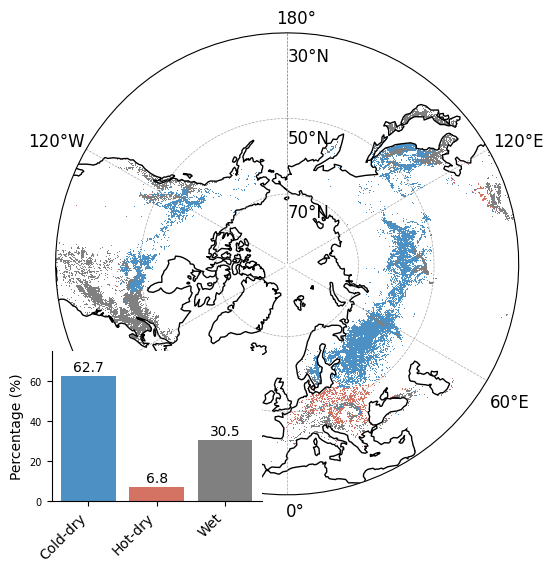

In [60]:
show_map(df)

Read vegetation data

In [61]:
veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
veg_class = veg_class[(veg_class['veg_class'] > 10) & (veg_class['veg_class'] < 15)]

In [62]:
## Forest map 
import matplotlib.pyplot as plt
import rasterio as rs
from rasterio.features import rasterize
import geopandas as gpd
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from shapely.geometry import box
import matplotlib.path as mpath
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# ------------------------------
# Rasterization
# ------------------------------
def rasterize_classification(gdf, transform, width, height, crs):
    shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf['veg_class']))
    class_raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=np.nan,
        dtype='float32'
    )
    print(f"[DEBUG] Vegetation pixels (non-NaN): {np.count_nonzero(~np.isnan(class_raster))}")
            
    # --- Land mask clipping ---
    import cartopy.io.shapereader as shpreader
    from shapely.geometry import box
    
    ne_path = shpreader.natural_earth(
        resolution="110m",
        category="physical",
        name="land"
    )
    land = gpd.read_file(ne_path).to_crs(crs)
    
    left, bottom, right, top = rs.transform.array_bounds(height, width, transform)
    raster_bounds = box(left, bottom, right, top)
    land = gpd.clip(land, gpd.GeoDataFrame(geometry=[raster_bounds], crs=crs))
    
    land_mask = rasterize(
        [(geom, 1) for geom in land.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint8"
    )
    
    class_raster = np.where(land_mask == 1, class_raster, np.nan)
    print("[DEBUG] Pixels after land mask:", np.count_nonzero(~np.isnan(class_raster)))
    
    return class_raster

# ------------------------------
# Plot vegetation raster
# ------------------------------
def show_classification_raster(class_raster, transform):
    fig = plt.figure(figsize=[6, 6])
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
    ax.coastlines()

    # Circular mask
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Colormap for 4 vegetation classes
    cmap = ListedColormap(['#05450a', '#54a708', '#78d203', '#009900'])
    labels = ['ENF', 'DNF', 'DBF', 'MF']
    class_codes = [11, 12, 13, 14]

    # Raster bounds
    left, bottom, right, top = rs.transform.array_bounds(
        class_raster.shape[0], class_raster.shape[1], transform
    )

    class_masked = np.ma.masked_invalid(class_raster)
    ax.imshow(
        class_masked,
        cmap=cmap,
        extent=[left, right, bottom, top],
        transform=ccrs.PlateCarree(),
        origin="upper",
        interpolation="nearest"
    )

    # ---------------------------------
    # Bar plot of percentages (inset)
    # ---------------------------------
    valid = class_raster[~np.isnan(class_raster)]
    if len(valid) > 0:
        counts = np.array([(valid == v).sum() for v in class_codes])
        percentages = counts / counts.sum() * 100
    else:
        percentages = np.zeros(4)

    ax_bar = fig.add_axes([0.12, 0.10, 0.35, 0.25])
    bars = ax_bar.bar(range(4), percentages, color=cmap.colors)
    ax_bar.set_xticks(range(4))
    ax_bar.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)
    ax_bar.set_ylabel("Percentage (%)", fontsize=10)
    ax_bar.set_ylim(0, max(percentages) * 1.2 if len(valid) > 0 else 1)
    ax_bar.spines["top"].set_visible(False)
    ax_bar.spines["right"].set_visible(False)
    ax_bar.tick_params(axis='y', labelsize=7)
    ax_bar.set_yticks([0, 20, 40, 60])

    for bar, pct in zip(bars, percentages):
        ax_bar.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 1,
            f"{pct:.1f}",
            ha='center', va='bottom', fontsize=10
        )

    # Gridlines + labels
    gl = ax.gridlines(linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
    gl.ylocator = mticker.FixedLocator([30, 50, 70])
    lat_formatter = LatitudeFormatter()
    lon_formatter = LongitudeFormatter()
    for lat in [30, 50, 70]:
        ax.text(180, lat + 5, lat_formatter(lat),
                transform=ccrs.PlateCarree(),
                ha='left', va='center', fontsize=12, color='black')
    for lon in np.arange(-180, 181, 60):
        if lon in [-180, -60]:
            continue
        label_lon, label_lat = lon, 25
        if lon in [-120, 120]:
            label_lat = 23
        if lon == 0:
            label_lon = 2
            label_lat = 29
        if lon == 180:
            label_lon = 178
        ax.text(label_lon, label_lat, lon_formatter(lon),
                transform=ccrs.PlateCarree(),
                ha='center', va='top', fontsize=12, color='black')

    fig.savefig("../results/ed_figures/ed_fig2/veg_classes.png", dpi=300, bbox_inches='tight')
    plt.show()

# ------------------------------
# Main wrapper
# ------------------------------
def show_map(df):
    with rs.open('../data/satellite_data/images/base-image/test.tif') as src:
        transform = src.transform
        width, height = src.width, src.height
        crs = src.crs

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs=crs
    )

    left, bottom, right, top = rs.transform.array_bounds(height, width, transform)
    raster_bounds = box(left, bottom, right, top)
    gdf = gdf[gdf.geometry.within(raster_bounds)]
    print(f"[DEBUG] Points inside raster bounds: {len(gdf)}")

    # No classification — use veg_class directly
    class_raster = rasterize_classification(gdf, transform, width, height, crs)
    show_classification_raster(class_raster, transform)


Plot Extended Data Fig. 2b

[DEBUG] Points inside raster bounds: 137101
[DEBUG] Vegetation pixels (non-NaN): 137101
[DEBUG] Pixels after land mask: 133975


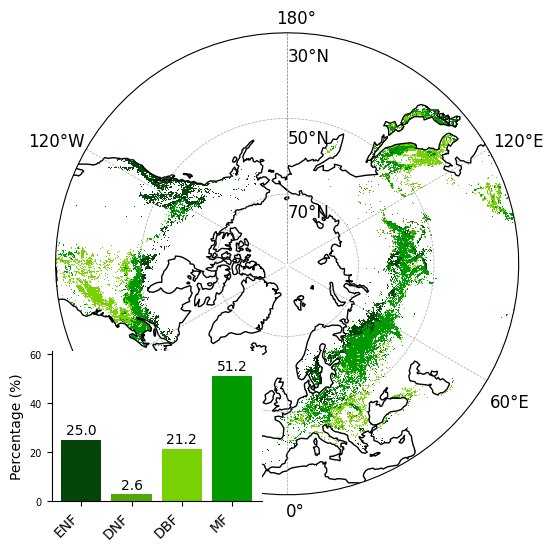

In [63]:
show_map(veg_class)

In [64]:
## AVHRR EOS map
import matplotlib.pyplot as plt
import rasterio as rs
from rasterio.features import rasterize
import geopandas as gpd
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import matplotlib.path as mpath
from matplotlib.colors import LinearSegmentedColormap

# --- Main display function ---
def show_raster_with_title_and_colorbar(raster, transform, name):
    fig = plt.figure(figsize=[6, 6])
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
    ax.coastlines()

    # Circular mask for polar projection
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Colormap
    cmap = LinearSegmentedColormap.from_list("custom_cmap",
        ["#0b3c68", "#165188", "#2066a8", "#4d91c4", "#8ec1da", 
         "#fbebe1", "#f6d6c2", "#d47264", "#c14d48", "#ae282c"]
    )

    # Define raster bounds
    left, bottom, right, top = rs.transform.array_bounds(raster.shape[0], raster.shape[1], transform)

    # Show raster
    # Show raster
    im = ax.imshow(
        raster,
        cmap=cmap,
        vmin=245,   # <--- full range for color scaling
        vmax=305,
        extent=[left, right, bottom, top],
        transform=ccrs.PlateCarree(),
        origin='upper'
    )

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar.set_label("EOS (DOY)", fontsize=14)

    # Only show ticks 240–310 even though colormap spans 235–315
    cbar.set_ticks(np.arange(250, 301, 10))
    cbar.ax.tick_params(labelsize=12)
    plt.tight_layout()

    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
    gl = ax.gridlines(linewidth=0.5,color='gray',alpha=0.7,linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
    gl.ylocator = mticker.FixedLocator([30,50,70])
    lat_formatter = LatitudeFormatter()
    lon_formatter = LongitudeFormatter()
    for lat in [30,50,70]:
        ax.text(180,lat+5,lat_formatter(lat),transform=ccrs.PlateCarree(),ha='left',va='center',fontsize=12,color='black')
    for lon in np.arange(-180,181,60):
        if lon == -180:
            continue
        label_lon, label_lat = lon, 25   # higher so not under colorbar
        if lon in [-120,120]:
            label_lat = 23
        if lon == 0:
            label_lon = 2
            label_lat = 29
        if lon == 180:
            label_lon = 178
        ax.text(label_lon,label_lat,lon_formatter(lon),
                transform=ccrs.PlateCarree(),
                ha='center',va='top',fontsize=12,color='black')

    plt.savefig("../results/ed_figures/ed_fig2/avhrr_eos_map.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- Rasterize EOS from df ---
def rasterize_data(gdf, transform, width, height, name, projection, crs):
    shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf['eos']))
    rasterized_data = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=np.nan,
        dtype='float32'
    )

    print(f"[DEBUG] Non-NaN values in raster: {np.count_nonzero(~np.isnan(rasterized_data))}")

    
    # --- Land mask clipping (inside rasterize_data) ---
    import cartopy.io.shapereader as shpreader
    from shapely.geometry import box
    
    # Load Natural Earth land polygons
    ne_path = shpreader.natural_earth(
        resolution="110m",
        category="physical",
        name="land"
    )
    land = gpd.read_file(ne_path).to_crs(crs)
    
    # Clip to raster extent
    left, bottom, right, top = rs.transform.array_bounds(height, width, transform)
    raster_bounds = box(left, bottom, right, top)
    land = gpd.clip(land, gpd.GeoDataFrame(geometry=[raster_bounds], crs=crs))
    
    # Rasterize land mask
    land_mask = rasterize(
        [(geom, 1) for geom in land.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint8"
    )
    
    # Apply land masking
    rasterized_data = np.where(land_mask == 1, rasterized_data, np.nan)
    print("[DEBUG] Pixels after land mask:", np.count_nonzero(~np.isnan(rasterized_data)))


    show_raster_with_title_and_colorbar(rasterized_data, transform, name)

# --- Preprocess and show map ---
def show_map(df):
    with rs.open('../data/satellite_data/images/base-image/test.tif') as src:
        transform = src.transform
        width, height = src.width, src.height
        crs = src.crs

    # Convert df to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs=crs
    )

    # Filter points inside raster bounds
    left, bottom, right, top = rs.transform.array_bounds(height, width, transform)
    raster_bounds = box(left, bottom, right, top)
    gdf = gdf[gdf.geometry.within(raster_bounds)]

    print(f"[DEBUG] Points inside raster bounds: {len(gdf)}")

    projection = ccrs.NorthPolarStereo(central_longitude=0)
    rasterize_data(gdf, transform, width, height, 'EOS', projection, crs)

Plot Extended Data Fig. 2c

[DEBUG] Points inside raster bounds: 128264
[DEBUG] Non-NaN values in raster: 128264
[DEBUG] Pixels after land mask: 126881


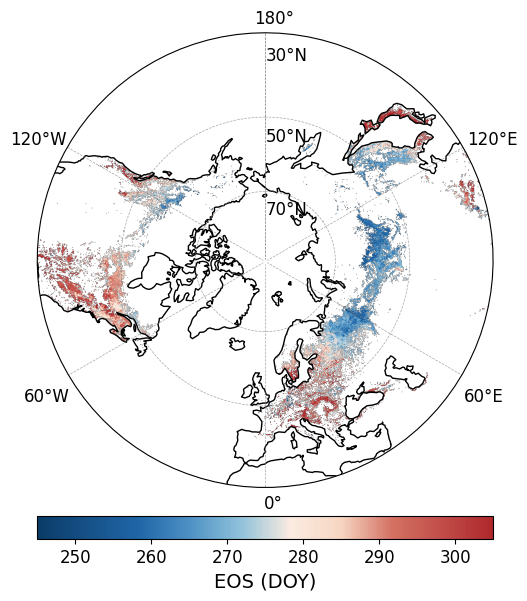

In [65]:
show_map(df)

Read PhenoCam data

In [48]:
import pandas as pd
df = pd.read_csv('../data/phenocam_data/tables/phenocam.csv')
eos_cols = [c for c in df.columns if c.startswith("eos_")]
df[eos_cols] = df[eos_cols].where(df[eos_cols] >= 200)
df = df[df['veg_type'].isin(["EN", "DB", "DN"])]
df = df[df['latitude'] >= 30]

In [49]:
## Get long-term mean
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def get_long_term_mean(df, threshold):
    # --- Identify relevant columns ---
    eos_cols = [c for c in df.columns if c.startswith("eos_")]
    annual_t_cols = [c for c in df.columns if c.startswith("annual_t_")]
    annual_p_cols = [c for c in df.columns if c.startswith("annual_p_")]

    eos_years = [int(c.split("_")[1]) for c in eos_cols]
    t_map = {int(c.split("_")[2]): c for c in annual_t_cols}
    p_map = {int(c.split("_")[2]): c for c in annual_p_cols}

    # --- Compute long-term means (only for valid EOS years) ---
    longterm_t, longterm_p, longterm_eos = [], [], []
    for _, row in df.iterrows():
        eos_values, t_values, p_values = [], [], []
        for year, eos_col in zip(eos_years, eos_cols):
            eos_val = row[eos_col]
            if pd.notna(eos_val):
                eos_values.append(eos_val)
                if year in t_map:
                    t_values.append(row[t_map[year]])
                if year in p_map:
                    p_values.append(row[p_map[year]])
        longterm_eos.append(np.nanmean(eos_values) if eos_values else np.nan)
        longterm_t.append(np.nanmean(t_values) if t_values else np.nan)
        longterm_p.append(np.nanmean(p_values) if p_values else np.nan)

    # --- Store and filter ---
    df = df.copy()
    df["longterm_eos"] = longterm_eos
    df["longterm_annual_t"] = np.array(longterm_t) - 273.5  # convert K → °C
    df["longterm_annual_p"] = longterm_p
    df = df[df["longterm_eos"] > 200]
    return df


In [50]:
threshold  = 0.8
long_term_mean_phenocam = get_long_term_mean(df, threshold)

Read FLUXNET data

In [51]:
import pandas as pd
df = pd.read_csv('../data/flux_data/tables/flux_50.csv')
eos_cols = [c for c in df.columns if c.startswith("eos_")]
df[eos_cols] = df[eos_cols].where(df[eos_cols] >= 200)
df = df[df['latitude'] >= 30]

In [52]:
## Get long-term mean
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def get_long_term_mean(df, threshold):
    # --- Identify relevant columns ---
    eos_cols = [c for c in df.columns if c.startswith("eos_")]
    annual_t_cols = [c for c in df.columns if c.startswith("annual_t_")]
    annual_p_cols = [c for c in df.columns if c.startswith("annual_p_")]

    eos_years = [int(c.split("_")[1]) for c in eos_cols]
    t_map = {int(c.split("_")[2]): c for c in annual_t_cols}
    p_map = {int(c.split("_")[2]): c for c in annual_p_cols}

    # --- Compute long-term means (only for valid EOS years) ---
    longterm_t, longterm_p, longterm_eos = [], [], []
    for _, row in df.iterrows():
        eos_values, t_values, p_values = [], [], []
        for year, eos_col in zip(eos_years, eos_cols):
            eos_val = row[eos_col]
            if pd.notna(eos_val):
                eos_values.append(eos_val)
                if year in t_map:
                    t_values.append(row[t_map[year]])
                if year in p_map:
                    p_values.append(row[p_map[year]])
        longterm_eos.append(np.nanmean(eos_values) if eos_values else np.nan)
        longterm_t.append(np.nanmean(t_values) if t_values else np.nan)
        longterm_p.append(np.nanmean(p_values) if p_values else np.nan)

    # --- Store and filter ---
    df = df.copy()
    df["longterm_eos"] = longterm_eos
    df["longterm_annual_t"] = np.array(longterm_t) - 273.5  # convert K → °C
    df["longterm_annual_p"] = longterm_p
    df = df[df["longterm_eos"] > 200]
    return df


In [53]:
threshold  = 0.9
long_term_mean_flux = get_long_term_mean(df, threshold)

In [54]:
## PhenoCam & FLUXNET & Spruce map
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.ticker as mticker
import pandas as pd

def show_sites_map(df_phenocam, df_flux):
    fig = plt.figure(figsize=[6, 6])
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
    ax.coastlines(linewidth=0.8, color="black")

    # Circular boundary for polar projection
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # --- Colormap for EOS ---
    eos_cmap = LinearSegmentedColormap.from_list(
        "eos_cmap",
        ["#0b3c68", "#165188", "#4d91c4", "#8ec1da",
         "#fbebe1", "#f6d6c2", "#d47264", "#ae282c"]
    )

    # --- Precipitation bins (in mm/year) ---
    bins = [0, 500, 1000, 1500, 2000]
    labels = ["0–500", "500–1000", "1000–1500", "1500–2000"]

    def add_precip_class(df):
        df["precip_class"] = pd.cut(df["longterm_annual_p"] * 1000,
                                    bins=bins, labels=labels, include_lowest=True)
        return df

    df_phenocam = add_precip_class(df_phenocam)
    df_flux = add_precip_class(df_flux)

    size_map = {"0–500": 5, "500–1000": 15, "1000–1500": 25, "1500–2000": 35}

    # --- Plot PhenoCam sites (circle) ---
    for label in labels:
        subset = df_phenocam[df_phenocam["precip_class"] == label]
        if subset.empty:
            continue
        ax.scatter(
            subset["longitude"], subset["latitude"],
            c=subset["longterm_eos"],
            s=size_map[label],
            cmap=eos_cmap, vmin=245, vmax=305,
            edgecolors="black", linewidths=0.3,
            transform=ccrs.PlateCarree(), alpha=0.9,
            marker='o', label=None
        )

    # --- Plot FLUXNET sites (diamond) ---
    for label in labels:
        subset = df_flux[df_flux["precip_class"] == label]
        if subset.empty:
            continue
        ax.scatter(
            subset["longitude"], subset["latitude"],
            c=subset["longterm_eos"],
            s=size_map[label],
            cmap=eos_cmap, vmin=245, vmax=305,
            edgecolors="black", linewidths=0.3,
            transform=ccrs.PlateCarree(), alpha=0.9,
            marker='D', label=None
        )

    import matplotlib.colors as mcolors
    # Value of EOS for the Spruce site
    spruce_eos = 306
    # Normalize according to your existing scatter vmin/vmax
    norm = mcolors.Normalize(vmin=245, vmax=305)  # same as scatter plots
    # Map the value directly through the colormap
    spruce_color = eos_cmap(norm(spruce_eos))
    # Plot the Spruce site
    ax.scatter(
        -93.4541, 47.5049,          # lon, lat
        marker='^',                  # triangle marker
        s=100,                       # size
        color=spruce_color,          # color from colormap
        edgecolor='black',
        linewidth=1,
        transform=ccrs.PlateCarree(),
        zorder=10,
        label="Spruce site"
    )
    

    # --- Precipitation size legend for PhenoCam (circle) and FLUXNET (diamond) ---
    handles_phenocam = [
        plt.scatter([], [], s=size_map[label],
                    marker='o',
                    facecolors='gray', edgecolors='black', alpha=0.8,
                    label=f"{label} mm/yr")      # ← explicitly empty label
        for label in labels
    ]



    handles_flux = [
        plt.scatter([], [], s=size_map[label],
                    marker='D',
                    facecolors='gray', edgecolors='black', alpha=0.8,
                    label=f"{label} mm/yr")
        for label in labels
    ]

    # Combine both legends
    handles_all = handles_phenocam + handles_flux

    leg = ax.legend(
        handles=handles_all,
        title="",
        loc="lower center",
        bbox_to_anchor=(0.5, -0.25),
        ncol=2,
        fontsize=9,
        title_fontsize=10,
        frameon=True
    )

    frame = leg.get_frame()
    frame.set_facecolor("white")
    frame.set_edgecolor("none")


    # --- Gridlines and lat/lon labels ---
    gl = ax.gridlines(linewidth=0.5, color='gray', alpha=0.6, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
    gl.ylocator = mticker.FixedLocator([30, 50, 70])

    lat_formatter = LatitudeFormatter()
    lon_formatter = LongitudeFormatter()
    for lat in [30, 50, 70]:
        ax.text(180, lat + 5, lat_formatter(lat), transform=ccrs.PlateCarree(),
                ha='left', va='center', fontsize=12, color='black')
    for lon in np.arange(-180, 181, 60):
        if lon == -180:
            continue
        label_lon, label_lat = lon, 25
        if lon in [-120, 120]:
            label_lat = 23
        if lon == 0:
            label_lon = 2
            label_lat = 29
        if lon == 180:
            label_lon = 178
        ax.text(label_lon, label_lat, lon_formatter(lon),
                transform=ccrs.PlateCarree(),
                ha='center', va='top', fontsize=12, color='black')

    plt.tight_layout()
    plt.savefig("../results/ed_figures/ed_fig2/phenocam_flux_map.png", dpi=300, bbox_inches='tight')
    plt.show()


Plot Extended Data Fig. 2d

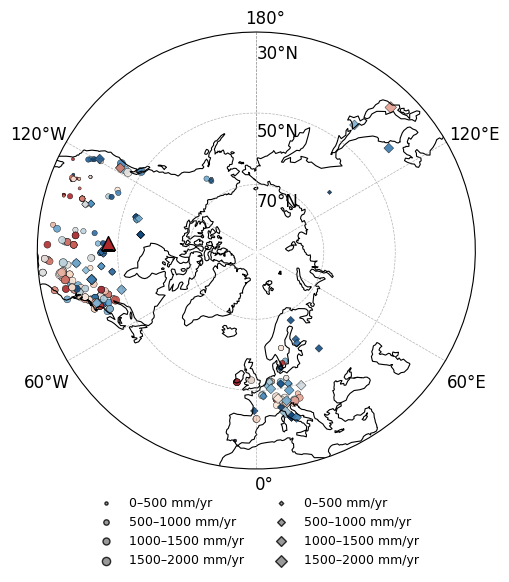

In [55]:
show_sites_map(long_term_mean_phenocam, long_term_mean_flux)